In [15]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import json
import requests
import pybea
from fredapi import Fred

%matplotlib inline
plt.style.use('fivethirtyeight')

Taylor rule (generic) : $i_t=\pi^*_t+\alpha_\pi(\pi_t - \pi^*_t)+\alpha_y(y_t - \bar y_t)$

But in this notebook this version was implemented - [Taylor Rule](https://fredblog.stlouisfed.org/2014/04/the-taylor-rule/)

In [2]:
bea_key = "567CF9BE-E8A9-4CDA-B7AF-09C85A7305A9"
fred_api_key = "f36460c2a6281a0f4dd8cec5576320ed"

trule_actuals = pd.read_csv(r'.\Data' + '\\' + 'taylor_rule_fred_actual.csv', parse_dates = True, index_col = ['Date'])

In [3]:
gdp_def = pybea.get_data(bea_key,
                         DataSetName='NIPA',
                         TableName = 'T10109',
                         Frequency = ['Q'],
                         Year = 'ALL',
                         ResultFormat = 'JSON')

In [4]:
ipd_gdp = gdp_def['LineDescription'] == 'Gross domestic product'

In [5]:
ipd_gdpdef = gdp_def[ipd_gdp]
ipd = pd.DataFrame(ipd_gdpdef[['TimePeriod','DataValue']])
ipd['Date'] = pd.date_range(start='1947-01-01', end = '2018-10-01', freq = 'Q')
ipd.set_index('Date', inplace = True)
ipd.drop(['TimePeriod'], axis = 1, inplace = True)
ipd.columns = ['GDP Deflator']

In [6]:
fred = Fred(api_key= fred_api_key)
output_gap = fred.get_series('GDPPOT')
real_gdp = pybea.get_data(bea_key,
                          DataSetName='NIPA',
                          TableName = 'T10106',
                          Frequency = ['Q'],
                          Year = 'ALL',
                          ResultFormat = 'JSON')

output_gap.index = pd.date_range(start = '1949-01-01', end = '2029-01-01',freq = 'Q')

fedfunds = fred.get_series('FEDFUNDS')
fedfunds_qtr = fedfunds.resample('Q').mean()

In [7]:
gdp = real_gdp[real_gdp['LineDescription'] == 'Gross domestic product']

In [8]:
gdp['TimePeriod'] = pd.to_datetime(gdp['TimePeriod'])
gdp_real = pd.DataFrame(gdp[['TimePeriod','DataValue']])
gdp_real.set_index('TimePeriod', inplace = True)
gdp_real.sort_index(inplace = True)
gdp_real.index = pd.date_range(start = '1947-01-01', end = '2018-10-01', freq='Q')
gdp_real.columns = ['Real GDP']

C:\Users\sidpa\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [9]:
gdp_real['Real GDP'] = gdp_real['Real GDP'].astype(float)

In [10]:
trule_actuals.index = pd.date_range(start = '1949-01', end = '2018-10', freq = 'Q')

In [13]:
taylor_us = (ipd.pct_change(4)['1960':].values*100 + 2 + 0.5*(ipd.pct_change(4)['1960':].values*100 - 2)+
             0.5*((gdp_real['1960':]).subtract(output_gap['1960':'2018-09'].to_frame().values*1000, axis = 'rows')/(output_gap['1960':'2018-09'].to_frame().values*10)))

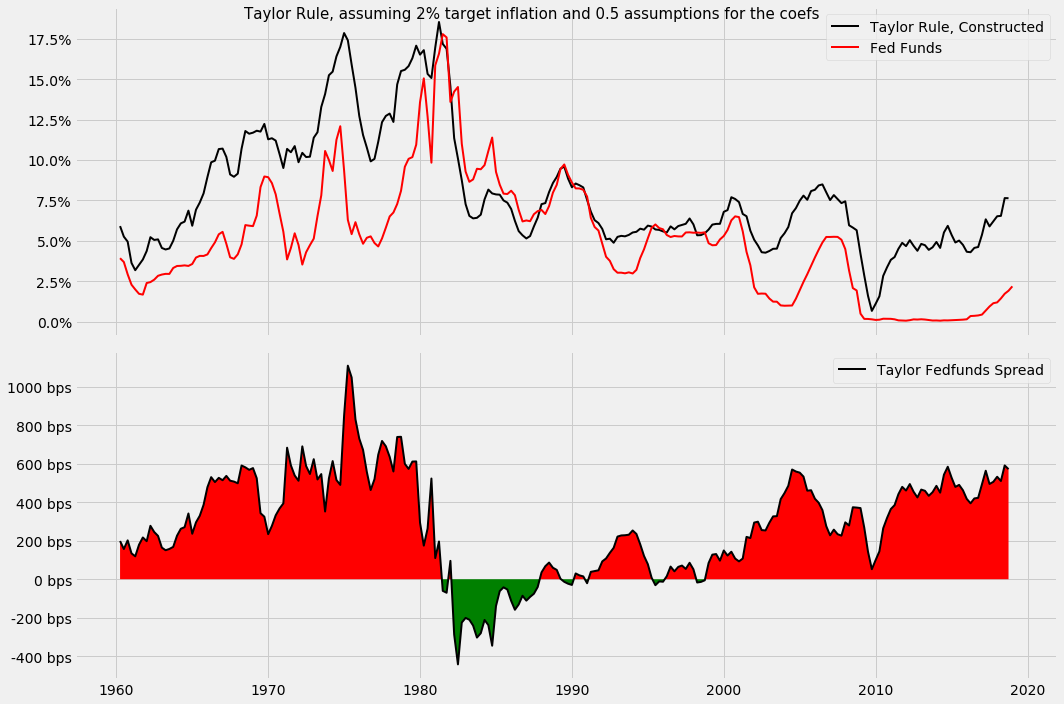

In [71]:
dates = taylor_us.index.values
diff = (taylor_us.subtract(fedfunds_qtr['1960':'2018-09'], axis = 'rows'))

fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize = [15,10])
plt.suptitle("Taylor Rule, assuming 2% target inflation and 0.5 assumptions for the coefs", fontsize = 15)

ax1.plot(taylor_us, color = 'black', linewidth = 2, label = 'Taylor Rule, Constructed')
ax1.plot(fedfunds_qtr['1960':], color = 'red', linewidth = 2, label = 'Fed Funds')
diffTickVal = ax1.get_yticks()
ax1.set_yticklabels(['{:,.1%}'.format(x/100) for x in diffTickVal])
ax1.legend()

ax2.plot(diff, color = 'black', linewidth = 2, label = 'Taylor Fedfunds Spread')
ax2.fill_between(dates, diff.iloc[:,0], 0, where = diff.iloc[:,0] >= 0, facecolor = 'red', interpolate=True)
ax2.fill_between(dates, diff.iloc[:,0], 0, where = diff.iloc[:,0] <= 0, facecolor = 'green', interpolate=True)
diffTickVal1 = ax2.get_yticks()
ax2.set_yticklabels(['%1.0f bps'% float(x*100) for x in diffTickVal1])
ax2.legend()
fig.tight_layout()

In [72]:
fig.savefig("TaylorRule")

**Successful replication!**

In [85]:
ind_prices = pd.read_csv(r'.\Data' + '\\' + 'india-other-price-indices.csv', parse_dates = True, index_col = ['Date'])
ind_prices.sort_index(inplace = True)

In [99]:
for i in range(0, len(ind_prices.columns)):
    ind_prices.iloc[:,i] = pd.to_numeric(ind_prices.iloc[:,i].str.replace("-",""), errors = 'coerce')

AttributeError: Can only use .str accessor with string values, which use np.object_ dtype in pandas

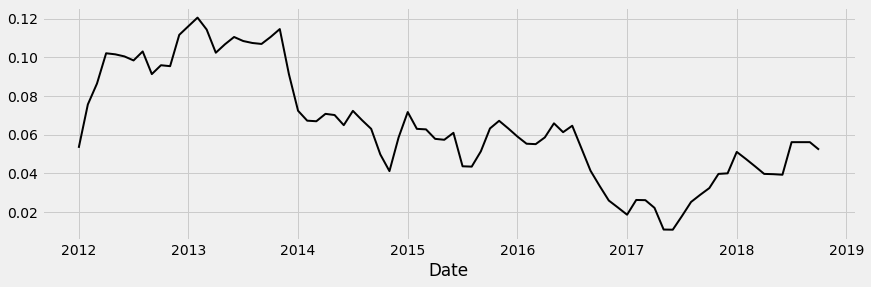

In [108]:
ind_prices['CPI-2001']['2011':].dropna().pct_change(12).plot(figsize = [13,4], color = 'black', linewidth = 2)

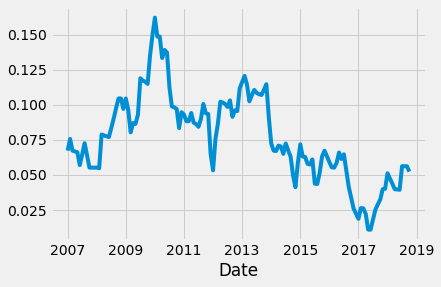

In [83]:
ind_prices['CPI-2001'].pct_change(12).plot()

In [106]:
ind_prices.tail()

,CPI-2001,CPI-1982,CPI-1960,CPI-AG-1987,CPI-AG-1961,CPI-RURAL-LABOR-2001,CPI-RURAL-LABOR-1987
Date,,,,,,,
2018-06-30,291.0,NaN,NaN,894.0,NaN,NaN,902.0
2018-07-31,301.0,NaN,NaN,902.0,NaN,NaN,910.0
2018-08-31,301.0,NaN,NaN,907.0,NaN,NaN,915.0
2018-09-30,301.0,NaN,NaN,910.0,NaN,NaN,917.0
2018-10-31,302.0,NaN,NaN,913.0,NaN,NaN,920.0


In [109]:
ind_inf = pd.ExcelFile(r'.\Data' + '\\' + 'wpi_index.xlsx')

In [110]:
ind_inf.sheet_names

['Base Year 1970-71',
 'Base Year 1981-82',
 'Base Year 1993-94',
 'Base Year 2004-05',
 'Base Year 2011-12']

In [111]:
wpi = ind_inf.parse(4)

In [ ]:
wpi['1 ALL COMMODITIES']

In [115]:
wpi.head(15)

,Month,1 ALL COMMODITIES,1.1 PRIMARY ARTICLES,1.1.1 FOOD ARTICLES,1.1.1.1 Food Grains (Cereals+Pulses),1.1.1.2 Fruits & Vegetables,1.1.1.3 Milk,"1.1.1.4 Eggs,Meat & Fish",1.1.1.5 Condiments & Spices,1.1.1.6 Other Food Articles,...,1.3.20.5 Other transport equipment,1.3.21 MANUFACTURE OF FURNITURE,1.3.21.1 Furniture,1.3.22 OTHER MANUFACTURING,1.3.22.1 Jewellery and Related articles,1.3.22.2 Musical instruments,1.3.22.3 Sports goods,1.3.22.4 Games and Toys,1.3.22.5 Medical and Dental instruments and Supplies,2 FOOD INDEX
0,Weights,100.00,22.618,15.256,3.462,3.475,4.44,2.402,0.529,0.948,...,0.002,0.727,0.727,1.064,0.996,0.001,0.012,0.005,0.049,24.378
1,Oct-2018,121.70,136.300,145.800,146.600,157.600,144.10,135.100,131.800,143.000,...,124.800,127.300,127.300,107.100,104.000,167.500,128.500,130.700,160.600,139.700
2,Sep-2018,120.80,135.400,144.500,145.400,154.000,143.50,134.200,133.700,143.700,...,124.100,125.400,125.400,107.000,103.800,167.100,127.700,133.800,160.600,138.900
3,Aug-2018,120.05,135.150,144.800,145.050,155.700,143.70,135.300,131.200,141.300,...,123.850,125.400,125.400,103.600,100.500,174.300,127.000,131.600,155.100,139.000
4,Jul-2018,119.80,135.100,144.750,142.650,155.800,143.20,139.300,130.550,140.850,...,121.750,125.200,125.200,105.800,102.950,168.900,126.300,129.600,154.900,138.850
5,Jun-2018,119.15,132.850,141.750,141.000,145.850,142.50,138.200,128.900,142.300,...,121.300,126.050,126.050,106.900,103.800,173.700,126.300,130.600,160.200,136.800
6,May-2018,118.10,131.000,140.200,140.800,140.750,141.75,136.600,127.750,144.200,...,121.600,125.650,125.650,106.900,103.800,178.700,126.450,131.700,160.000,135.350
7,Apr-2018,117.05,129.950,139.800,140.400,142.750,141.20,132.500,127.300,145.750,...,121.250,124.300,124.300,105.350,102.350,182.700,126.350,129.950,155.600,135.300
8,Mar-2018,116.15,127.800,137.250,140.400,132.300,140.70,133.100,128.000,143.400,...,121.200,124.250,124.250,104.250,101.200,180.000,125.500,129.100,155.900,133.650
9,Feb-2018,115.95,128.000,137.850,139.900,133.750,140.60,134.700,131.700,144.000,...,121.200,121.700,121.700,107.700,104.900,180.900,125.600,130.100,155.600,133.600


In [119]:
wpi2011 = wpi[['Month','1 ALL COMMODITIES']][1:]
#wpi2011.index = pd.date_range(start = '')

In [123]:
wpi2011['Month'] = pd.to_datetime(wpi2011['Month'])
wpi2011.set_index('Month', inplace = True)
wpi2011.sort_index(inplace = True)
wpi2011.columns = ['WPI All Commodities']

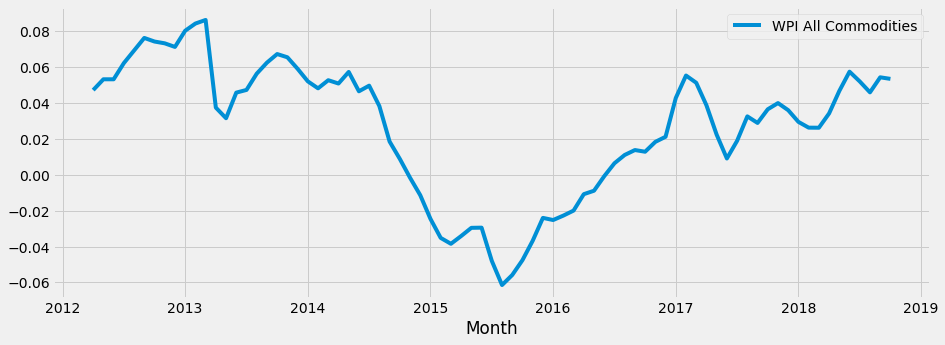

In [126]:
wpi2011.pct_change(12).plot(figsize = [14,5])

In [127]:
ind_inf.sheet_names

['Base Year 1970-71',
 'Base Year 1981-82',
 'Base Year 1993-94',
 'Base Year 2004-05',
 'Base Year 2011-12']

In [129]:
wpi2004 = ind_inf.parse(3)
wpi2004_allcomm = wpi2004[2:][['Unnamed: 1','1 ALL COMMODITIES']]
wpi2004_allcomm.columns = ['Date','WPI 2004']
wpi2004_allcomm['Date'] = pd.to_datetime(wpi2004_allcomm['Date'])
wpi2004_allcomm.set_index('Date', inplace = True)
wpi2004_allcomm.sort_index(inplace = True)

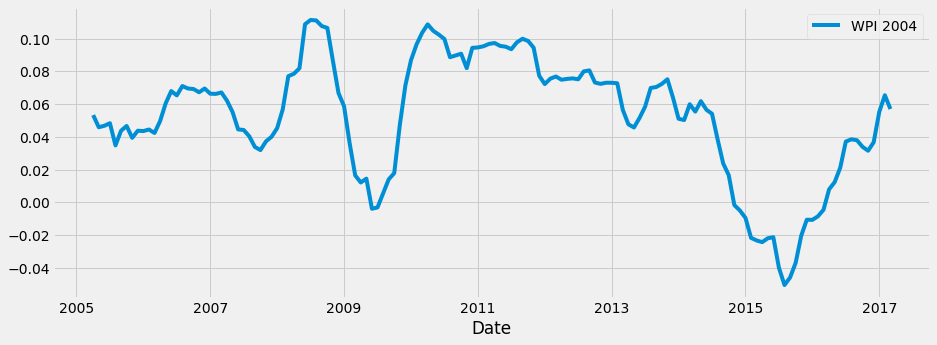

In [130]:
wpi2004_allcomm.pct_change(12).plot(figsize = [14,5])

In [132]:
wpi.head(12)

,Month,1 ALL COMMODITIES,1.1 PRIMARY ARTICLES,1.1.1 FOOD ARTICLES,1.1.1.1 Food Grains (Cereals+Pulses),1.1.1.2 Fruits & Vegetables,1.1.1.3 Milk,"1.1.1.4 Eggs,Meat & Fish",1.1.1.5 Condiments & Spices,1.1.1.6 Other Food Articles,...,1.3.20.5 Other transport equipment,1.3.21 MANUFACTURE OF FURNITURE,1.3.21.1 Furniture,1.3.22 OTHER MANUFACTURING,1.3.22.1 Jewellery and Related articles,1.3.22.2 Musical instruments,1.3.22.3 Sports goods,1.3.22.4 Games and Toys,1.3.22.5 Medical and Dental instruments and Supplies,2 FOOD INDEX
0,Weights,100.00,22.618,15.256,3.462,3.475,4.44,2.402,0.529,0.948,...,0.002,0.727,0.727,1.064,0.996,0.001,0.012,0.005,0.049,24.378
1,Oct-2018,121.70,136.300,145.800,146.600,157.600,144.10,135.100,131.800,143.000,...,124.800,127.300,127.300,107.100,104.000,167.500,128.500,130.700,160.600,139.700
2,Sep-2018,120.80,135.400,144.500,145.400,154.000,143.50,134.200,133.700,143.700,...,124.100,125.400,125.400,107.000,103.800,167.100,127.700,133.800,160.600,138.900
3,Aug-2018,120.05,135.150,144.800,145.050,155.700,143.70,135.300,131.200,141.300,...,123.850,125.400,125.400,103.600,100.500,174.300,127.000,131.600,155.100,139.000
4,Jul-2018,119.80,135.100,144.750,142.650,155.800,143.20,139.300,130.550,140.850,...,121.750,125.200,125.200,105.800,102.950,168.900,126.300,129.600,154.900,138.850
5,Jun-2018,119.15,132.850,141.750,141.000,145.850,142.50,138.200,128.900,142.300,...,121.300,126.050,126.050,106.900,103.800,173.700,126.300,130.600,160.200,136.800
6,May-2018,118.10,131.000,140.200,140.800,140.750,141.75,136.600,127.750,144.200,...,121.600,125.650,125.650,106.900,103.800,178.700,126.450,131.700,160.000,135.350
7,Apr-2018,117.05,129.950,139.800,140.400,142.750,141.20,132.500,127.300,145.750,...,121.250,124.300,124.300,105.350,102.350,182.700,126.350,129.950,155.600,135.300
8,Mar-2018,116.15,127.800,137.250,140.400,132.300,140.70,133.100,128.000,143.400,...,121.200,124.250,124.250,104.250,101.200,180.000,125.500,129.100,155.900,133.650
9,Feb-2018,115.95,128.000,137.850,139.900,133.750,140.60,134.700,131.700,144.000,...,121.200,121.700,121.700,107.700,104.900,180.900,125.600,130.100,155.600,133.600


In [133]:
wpi2011_all = wpi[1:]
wpi2011_all['Month'] = pd.to_datetime(wpi2011_all['Month'])
wpi2011_all.set_index('Month', inplace = True)
wpi2011_all.sort_index(inplace = True)

C:\Users\sidpa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\sidpa\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [145]:
wpi_comps = [s.strip() for s in wpi2011_all.columns]
wpi2011_all.columns = wpi_comps

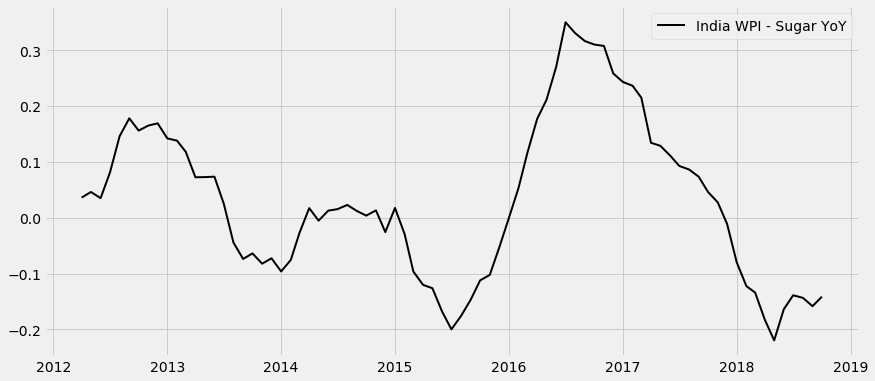

In [149]:
plt.figure(figsize = [13,6])
plt.plot(wpi2011_all['1.3.1.9 Sugar, Molasses & honey'].pct_change(12), color = 'black', linewidth = 2, label = 'India WPI - Sugar YoY')
plt.legend()

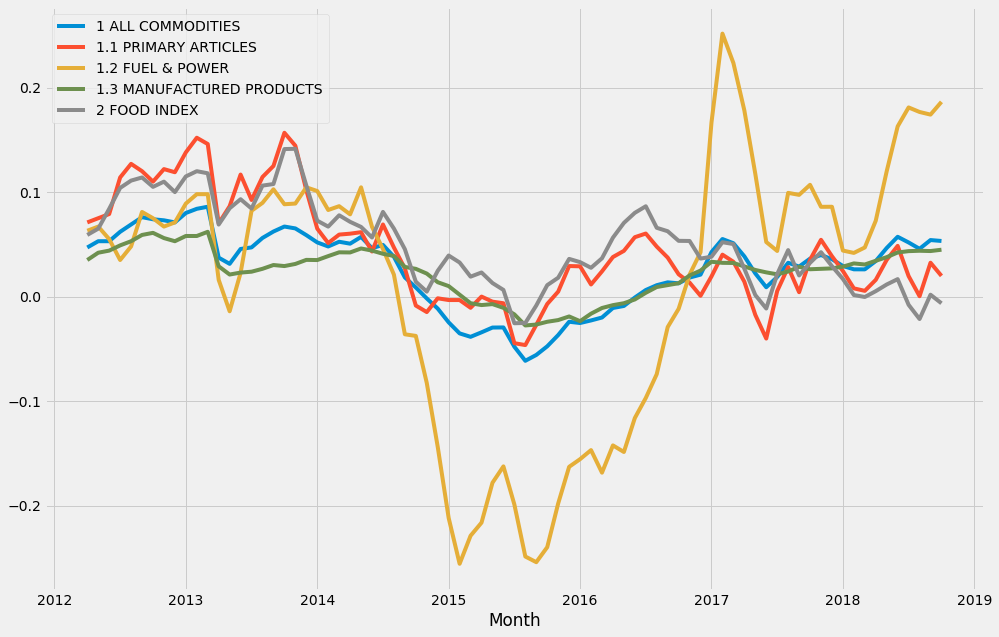

In [140]:
wpi2011_all[['1 ALL COMMODITIES','1.1 PRIMARY ARTICLES','1.2 FUEL & POWER','1.3 MANUFACTURED PRODUCTS','2 FOOD INDEX']].pct_change(12).plot(figsize = [15,10])